In [1]:
import os
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
from image_inpainting.datamodule.image_net_data_module import ImageNetDataModule
from pytorch_lightning.callbacks import ModelCheckpoint
from image_inpainting.model.context_encoder import ContextEncoder
from image_inpainting.utils import print_results_images

In [2]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")

## Create datamodule

In [3]:
data_dir = "data"

dm = ImageNetDataModule(
    data_dir=os.path.join(data_dir, "imagenet"), 
    batch_size_train=128,
    batch_size_val=128,
    batch_size_test=128,
    num_workers=10, 
    pin_memory=True, 
    persistent_workers=True
)

## Create a ContextEncoder model from scratch

In [4]:
model = ContextEncoder(input_size=(3, 128, 128), hidden_size=4000, save_image_per_epoch=True)

## Or load it from a checkpoint

In [11]:
# model = ContextEncoder.load_from_checkpoint("checkpoints/imagenet_64/current_date=0-epoch=epoch=05-val_loss=val_loss=3.65.ckpt") # change the path to your checkpoint
# model.enable_save_image_per_epoch()
# model.to("cuda")

ContextEncoder(
  (psnr_metric): PeakSignalNoiseRatio()
  (joint_loss): JointLoss(
    (rec_loss): ReconstructionLoss()
    (adv_loss): AdversarialLoss()
  )
  (rec_loss): ReconstructionLoss()
  (adv_loss): AdversarialLoss()
  (generator): AdversarialGenerator(
    (encoder): Encoder(
      (encoder): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (

## Train it

In [5]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/imagenet_64',
    filename=now+'-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_top_k=-1,  # Save all checkpoints
    every_n_epochs=1  # Save checkpoint every n epochs
)

tb_logger = pl_loggers.TensorBoardLogger("Context_Encoder_Inpainting")
trainer = pl.Trainer(max_epochs=300, devices=-1, accelerator="cuda", logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model, dm)

# To continue training:
# trainer.fit(model, dm, ckpt_path="checkpoints/imagenet_64/???.ckpt")

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Note: The ImageNet dataset can't be downloaded automatically. Please refer to the README if you haven't already downloaded it. Otherwise you can skip this message.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | psnr_metric   | PeakSignalNoiseRatio     | 0      | train
1 | joint_loss    | JointLoss                | 0      | train
2 | rec_loss      | ReconstructionLoss       | 0      | train
3 | adv_loss      | AdversarialLoss          | 0      | train
4 | generator     | AdversarialGenerator     | 71.1 M | train
5 | discriminator | AdversarialDiscriminator | 2.8 M  | train
-------------------------------------------------------------------
73.9 M    Trainable params
0         Non-trainable params
73.9 M    Total params
295.556   Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


Epoch 0:  49%|████▉     | 4562/9223 [12:24<12:40,  6.13it/s, v_num=0, train_psnr=16.40, train_loss_context_encoder=0.251, train_loss_discriminator=1.23e-14]

A notebook "tensorboard" exists if you want to check how the metrics evolve during training

## Display some images and evaluate the model performances

Here the results of this cell are after 19 epochs on the full Image Net dataset cropped and resized to 64x64.

- **Number of steps**: 369 249
- **Time**: 10h30
- **Observation (with tensorboard)**: There is overfitting starrting at epoch 6. So in the cell after this one we will display results at epoch 5 to compare. This early overfitting is maybe related to the size of images (the paper use larger images, but it's difficult to run it on our machines). We should also note that this paper provide few information on hyperparameters (e.g. betas for Adam). So differences can also come from here.

Note: The ImageNet dataset can't be downloaded automatically. Please refer to the README if you haven't already downloaded it. Otherwise you can skip this message.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1563/1563 [01:05<00:00, 23.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR           16.590456008911133
        test_loss           3.9826812744140625
        test_psnr           16.590356826782227
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


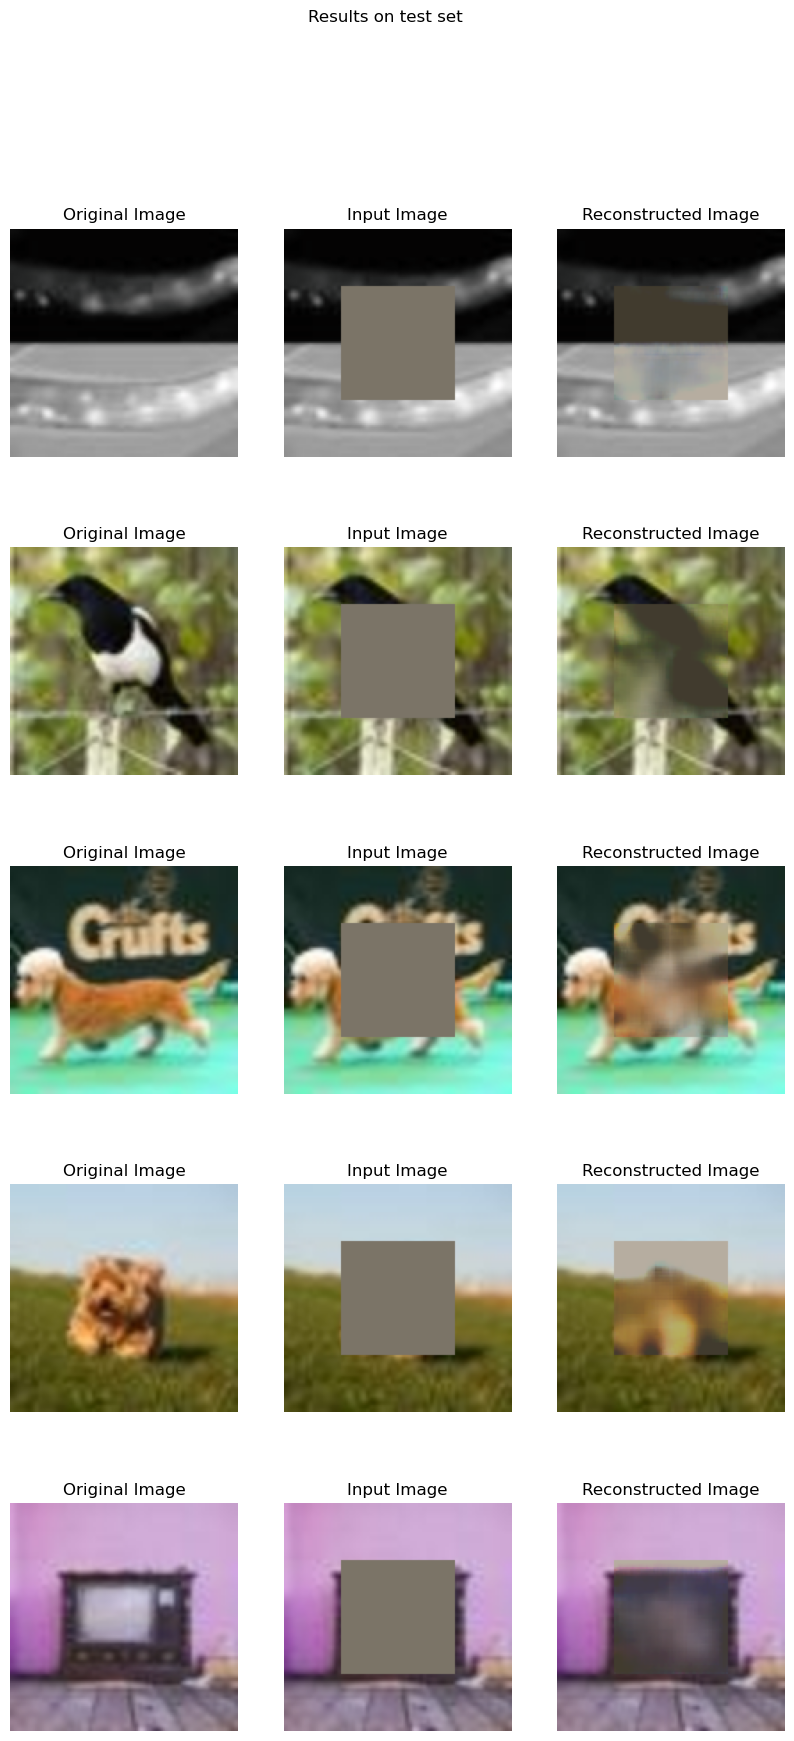

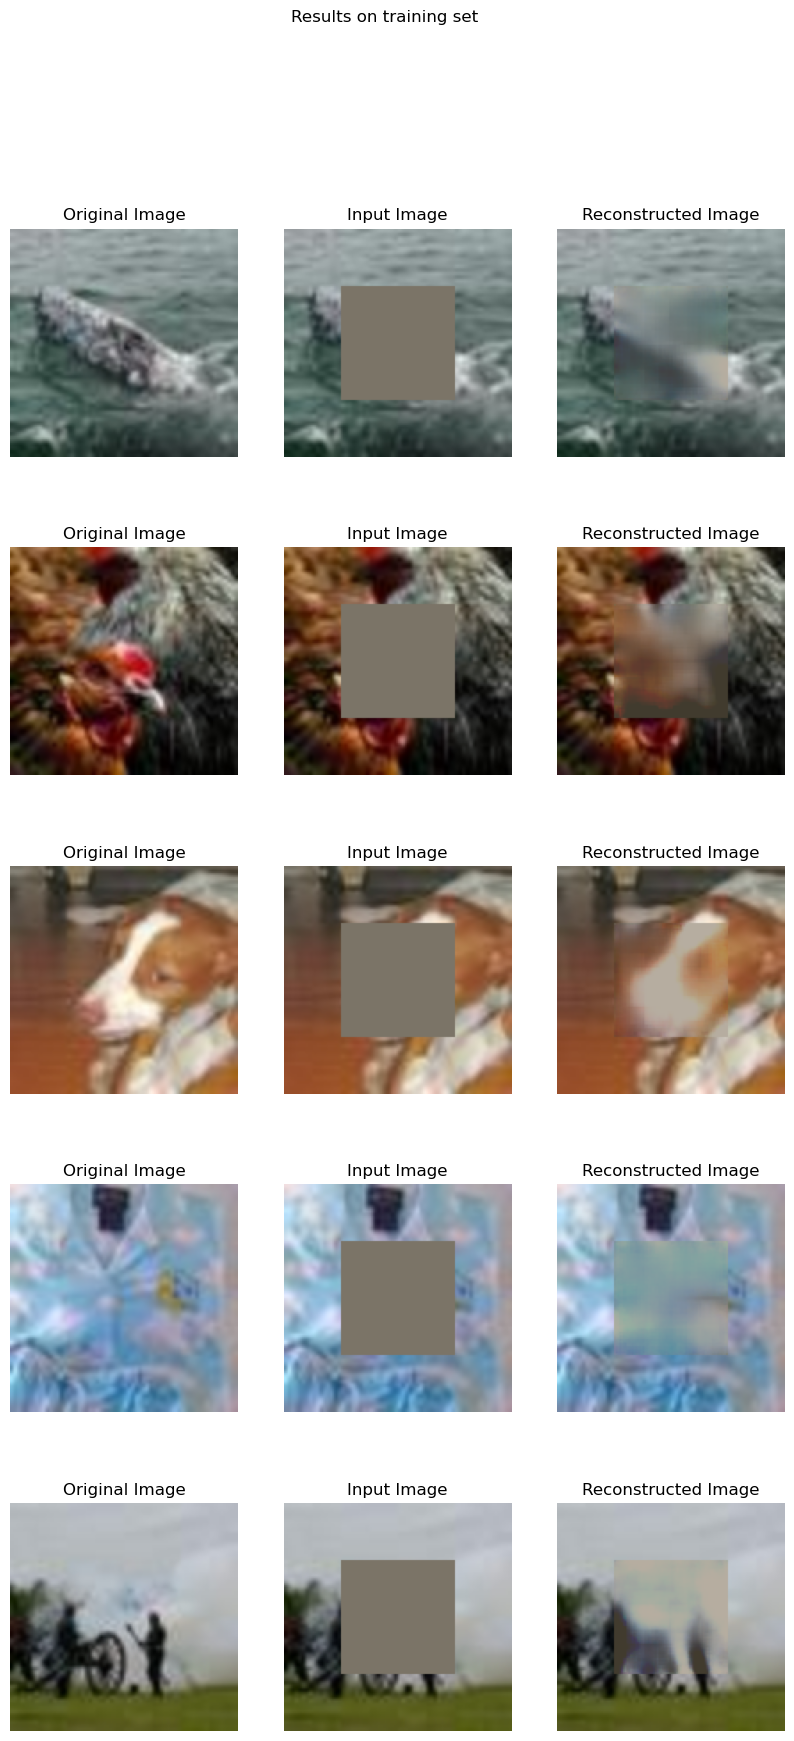

In [7]:
trainer.test(model, dm)

x, y = next(iter(dm.test_dataloader()))
    
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)

## Results on the best validation loss model

Here the results of this cell are after 5 epochs on the full Image Net dataset cropped and resized to 64x64.


- **Number of steps**: around 95 000
- **Time**: around 2h30

Note: The ImageNet dataset can't be downloaded automatically. Please refer to the README if you haven't already downloaded it. Otherwise you can skip this message.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1563/1563 [00:33<00:00, 47.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR            16.92247200012207
        test_loss           3.6204235553741455
        test_psnr           16.922334671020508
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


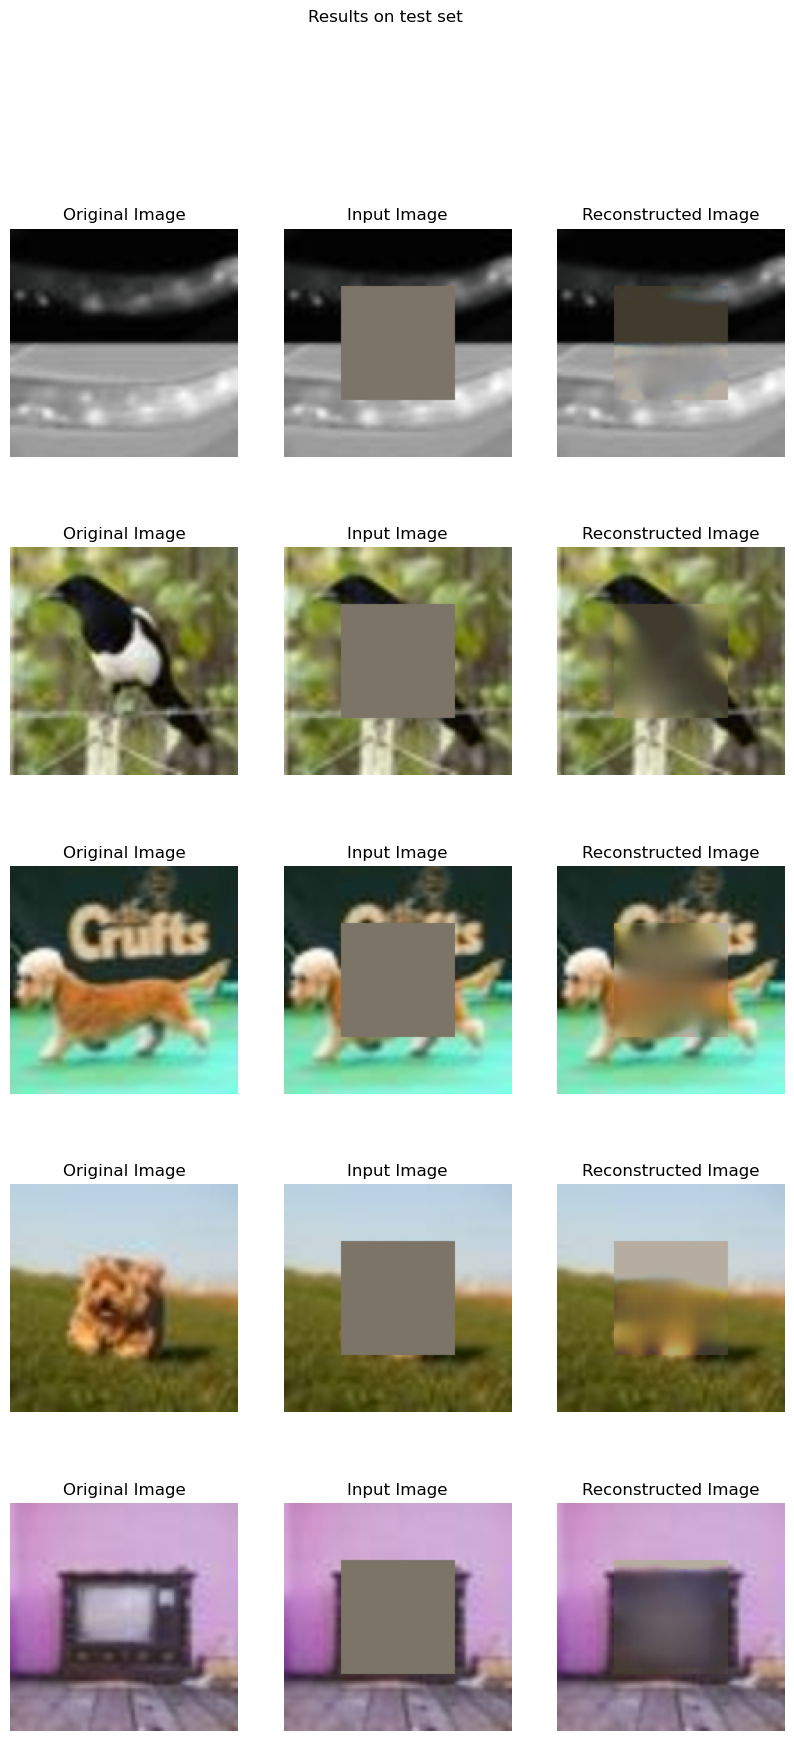

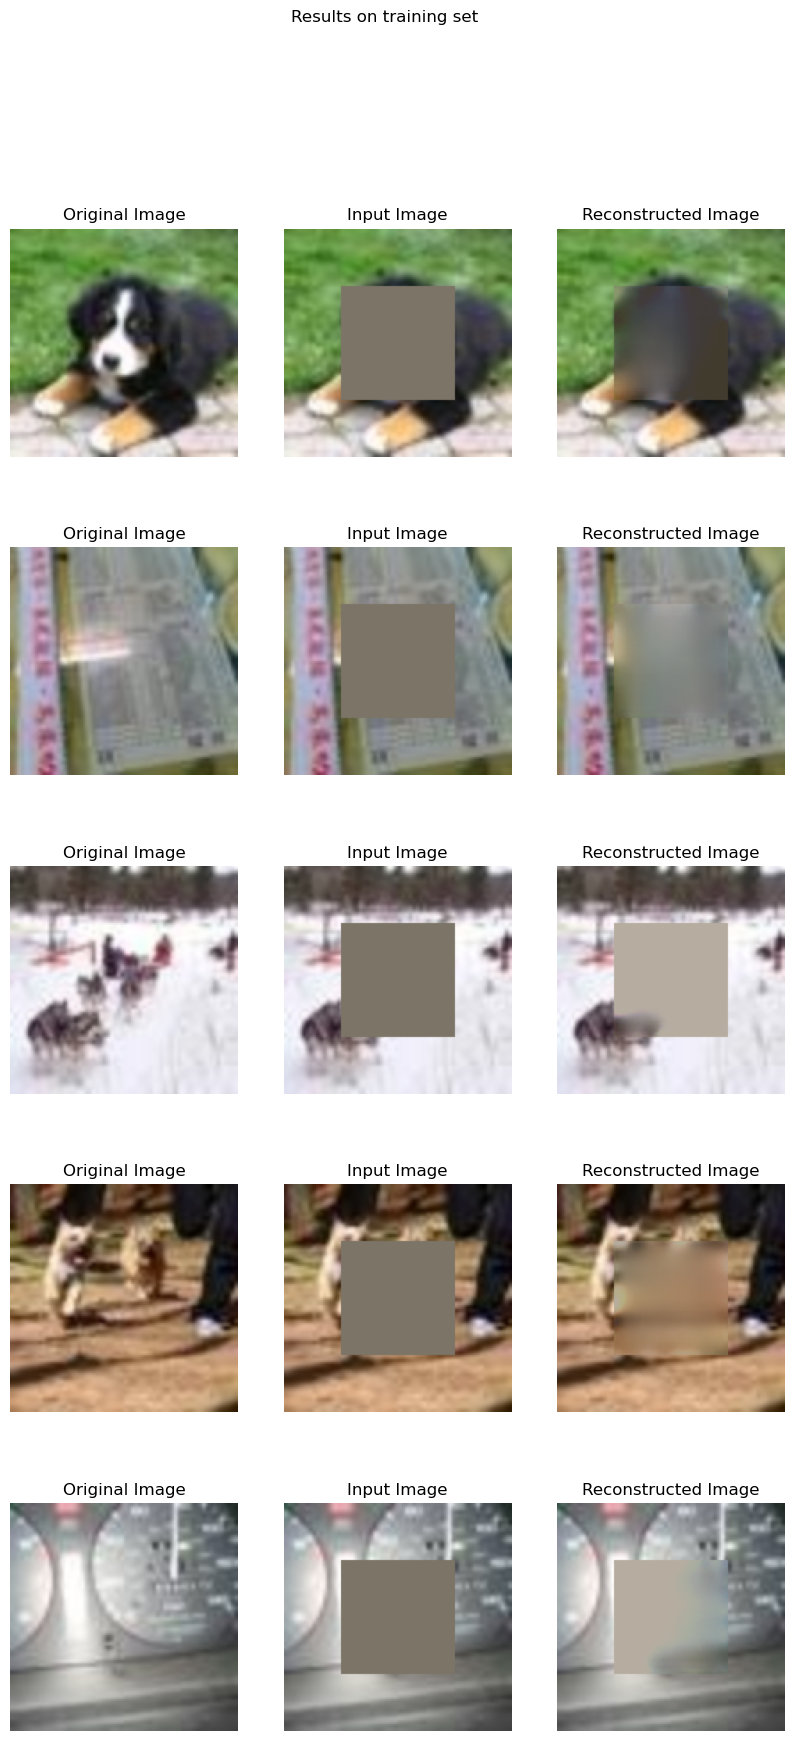

In [14]:
trainer.test(model, dm)

x, y = next(iter(dm.test_dataloader()))
    
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)